In [1]:
import os

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import utils.histoHelpers as uhh

from mvatrain.ROCPlot import ROCPlot

plt.style.use('default')
plt.rcParams.update(uhh.ffPltStyleSettings)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
summary_file = os.environ['FFANA_BASE']+'/mvatrain/output/summary.csv'
df = pd.read_csv(summary_file)
df["rel_improv"] = (1 - df["test-auc-mean"][0])/(1 - df["test-auc-mean"])
df["rel_improv_err"] = (df["test-auc-std"]**2 + df["test-auc-std"][0]**2)**0.5

In [5]:
x = df.index.values
y = df["rel_improv"].values
y_err = [0]*len(y)#df["rel_improv_err"].values

Text(0, 0.5, '(1-AUC)/(1-AUC_default)')

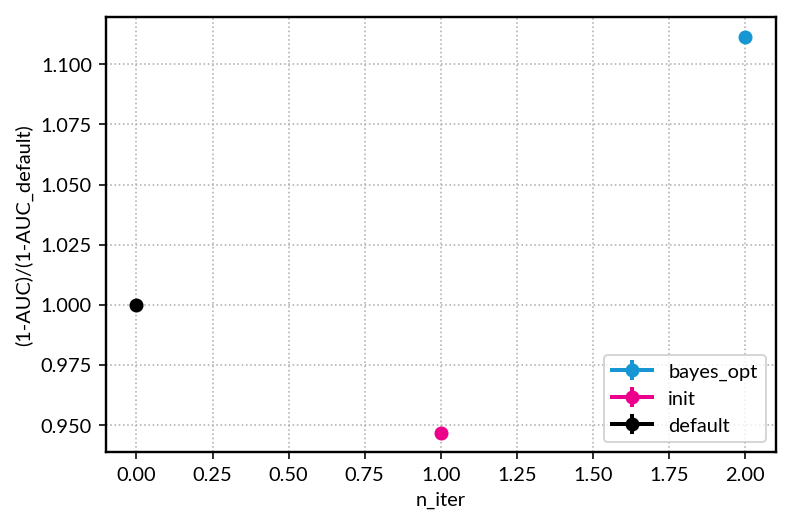

In [9]:
plt.errorbar(x[2:] , y[2:],  yerr=y_err[2:], fmt='o-', label='bayes_opt')
plt.errorbar(x[1:2], y[1:2], yerr=y_err[1:2], fmt='o-', label='init')
plt.errorbar(x[0]  , y[0],   yerr=y_err[0], fmt='o-', label='default')
plt.legend(loc="lower right")
# plt.xlim(-2, 60)
plt.xlabel("n_iter")
plt.ylabel("(1-AUC)/(1-AUC_default)")

In [2]:
h5file = '../output/pt_eta_score.h5'
df = pd.read_hdf(h5file)

/uscms/home/wsi/nobackup/lpcdm/ffAna/mvatrain/ROCPlot.py:94: RuntimeWarning: invalid value encountered in true_divide
  r = fpr / np.interp(tpr, self.tpr_ref, self.fpr_ref)
/uscms/home/wsi/nobackup/lpcdm/ffAna/mvatrain/ROCPlot.py:94: RuntimeWarning: invalid value encountered in true_divide
  r = fpr / np.interp(tpr, self.tpr_ref, self.fpr_ref)


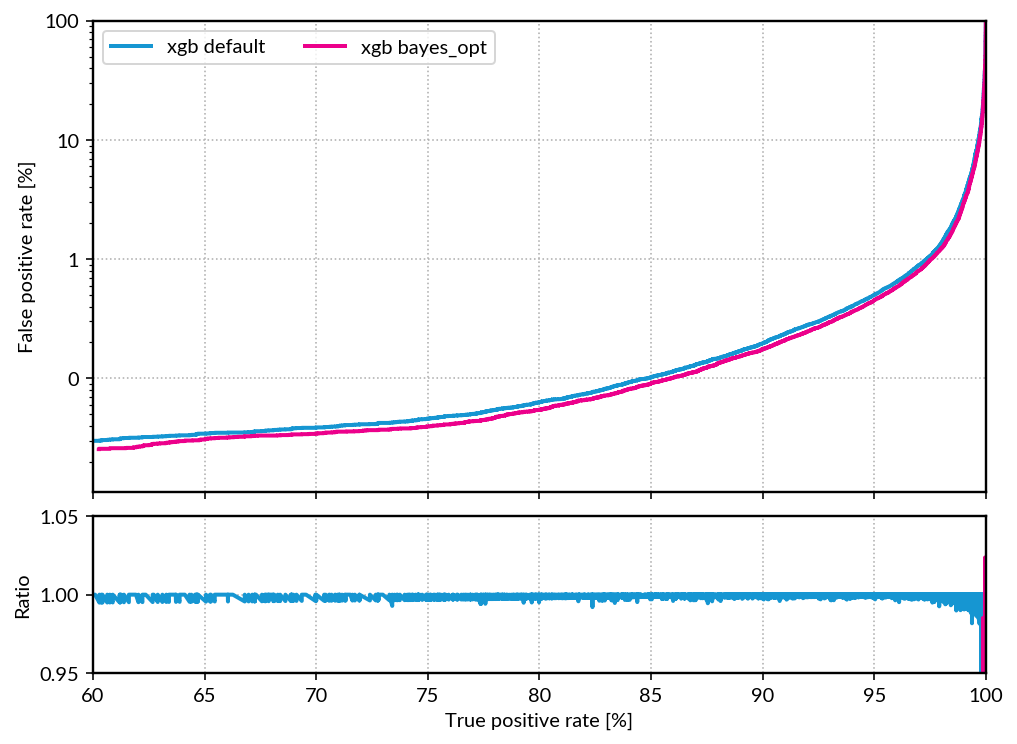

In [3]:
plt.figure(figsize=(8,6))
roc = ROCPlot(xlim=(0.6,1), ylim=(0.00011, 1), logscale=True, grid=True, percent=True, height_ratios=[3,1], ncol=2, rlim=(0.95, 1.05))
roc.plot(df['target']==True, df['bdt_score_default'], label='xgb default')
roc.plot(df['target']==True, df['bdt_score_optimized'], label='xgb bayes_opt')

In [4]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(df['target']==True, df['bdt_score_default'])

In [16]:
# 0.01
print("target", 'Fake positive rate', "True positive rate", "Threshold", sep='\t')
for m in [0.0001, 0.001, 0.01]:
    mask = fpr>m
    fpr_ = fpr[mask][0]
    tpr_ = tpr[mask][0]
    thres_ = thresholds[mask][0]
    print(m, fpr_, tpr_, thres_, sep='\t')

target	Fake positive rate	True positive rate	Threshold
0.0001	0.00010055304172951231	0.2633745520291867	7.88418
0.001	0.0010009598244892363	0.8485293642850225	4.5209374
0.01	0.010000457059280588	0.9734768992348174	1.004864


# prediction distribution

In [3]:
from os.path import join
DATA_PATH = join(os.environ["FFANA_BASE"], "mvatrain/data/combo_190530.awkd")
OUTPUT_DIR = join(os.environ["FFANA_BASE"], "mvatrain/output0530") 

In [5]:
xgbm_default = xgb.Booster({"nthread": 16})
xgbm_default.load_model(join(OUTPUT_DIR, "model_default/model.bin"))
xgbm_optimized = xgb.Booster({"nthread": 16})
xgbm_optimized.load_model(join(OUTPUT_DIR, "model_optimized/model.bin"))

import awkward
dataset_ = awkward.load(DATA_PATH)
df = pd.DataFrame(dict(dataset_))
df.fillna(0)
feature_cols = [n for n in dataset_.keys() if n != "target"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols], df["target"], random_state=42, test_size=0.25
)
xgtest = xgb.DMatrix(X_test, label=y_test)

preds_default = xgbm_default.predict(xgtest)
preds_optimized = xgbm_optimized.predict(xgtest)

/uscms/home/wsi/nobackup/miniconda3/envs/ffAna/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [10]:
xgtrain = xgb.DMatrix(X_train, label=y_train)
trainPreds_default = xgbm_default.predict(xgtrain)
trainPreds_optimized = xgbm_optimized.predict(xgtrain)

In [17]:
import inspect

def hist_errorbars( data, xerrs=True, *args, **kwargs) :
    """Plot a histogram with error bars. Accepts any kwarg accepted by either numpy.histogram or pyplot.errorbar"""
    # pop off normed kwarg, since we want to handle it specially
    norm = False
    if 'normed' in kwargs.keys() :
        norm = kwargs.pop('normed')

    # retrieve the kwargs for numpy.histogram
    histkwargs = {}
    for key, value in kwargs.items() :
        if key in inspect.getargspec(np.histogram).args :
            histkwargs[key] = value

    histvals, binedges = np.histogram( data, **histkwargs )
    yerrs = np.sqrt(histvals)

    if norm :
        nevents = float(sum(histvals))
        binwidth = (binedges[1]-binedges[0])
        histvals = histvals/nevents/binwidth
        yerrs = yerrs/nevents/binwidth

    bincenters = (binedges[1:]+binedges[:-1])/2

    if xerrs :
        xerrs = (binedges[1]-binedges[0])/2
    else :
        xerrs = None

    # retrieve the kwargs for errorbar
    ebkwargs = {}
    for key, value in kwargs.items() :
        if key in inspect.getfullargspec(plt.errorbar).args :
            histkwargs[key] = value
    out = plt.errorbar(bincenters, histvals, yerrs, xerrs, fmt=".", **ebkwargs)

    if 'log' in kwargs.keys() :
        if kwargs['log'] :
            plt.yscale('log')

    if 'range' in kwargs.keys() :
        plt.xlim(*kwargs['range'])

    return out

/uscms/home/wsi/nobackup/miniconda3/envs/ffAna/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  del sys.path[0]


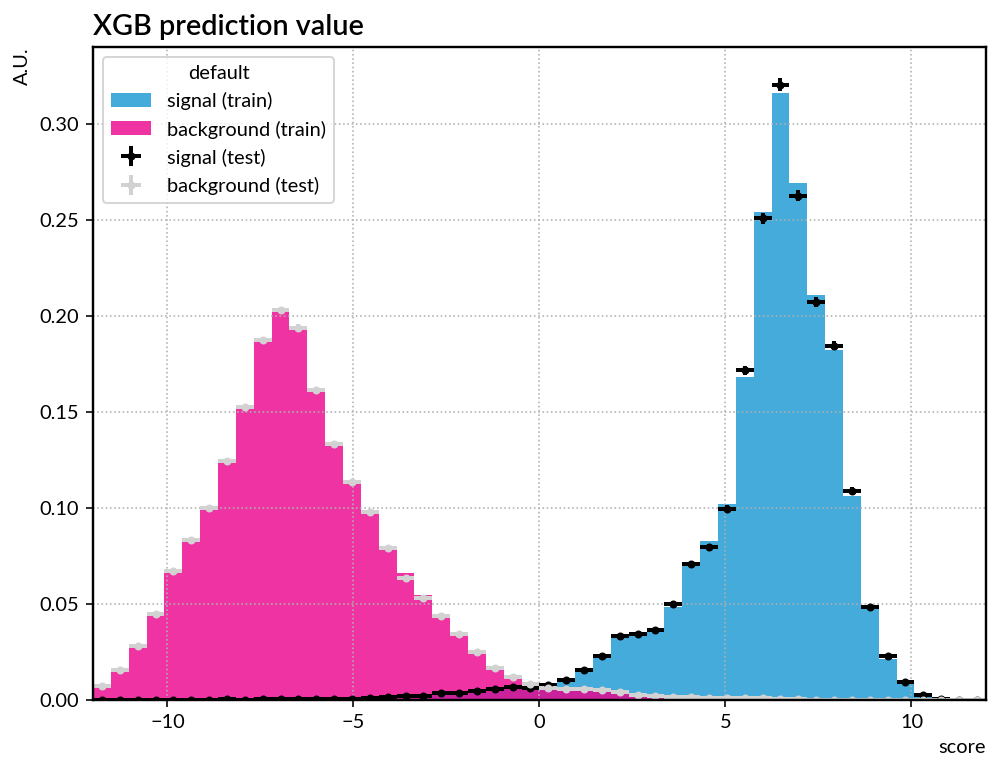

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(trainPreds_default[y_train], range=[-12, 12], bins=50, histtype="stepfilled", alpha=0.8, density=True, linewidth=2, label="signal (train)")
ax.hist(trainPreds_default[~y_train], range=[-12,12], bins=50, histtype="stepfilled", alpha=0.8, density=True, linewidth=2, label="background (train)")

hist_errorbars(preds_default[y_test], range=[-12, 12], bins=50, normed=True, ax=ax).set_label('signal (test)')
hist_errorbars(preds_default[~y_test], range=[-12, 12], bins=50, normed=True, ax=ax).set_label('background (test)')
ax.legend(title="default")
ax.set_xlabel("score", x=1, ha='right')
ax.set_ylabel("A.U.", y=1, ha='right')
ax.set_title("XGB prediction value", x=0, ha='left');

/uscms/home/wsi/nobackup/miniconda3/envs/ffAna/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  del sys.path[0]


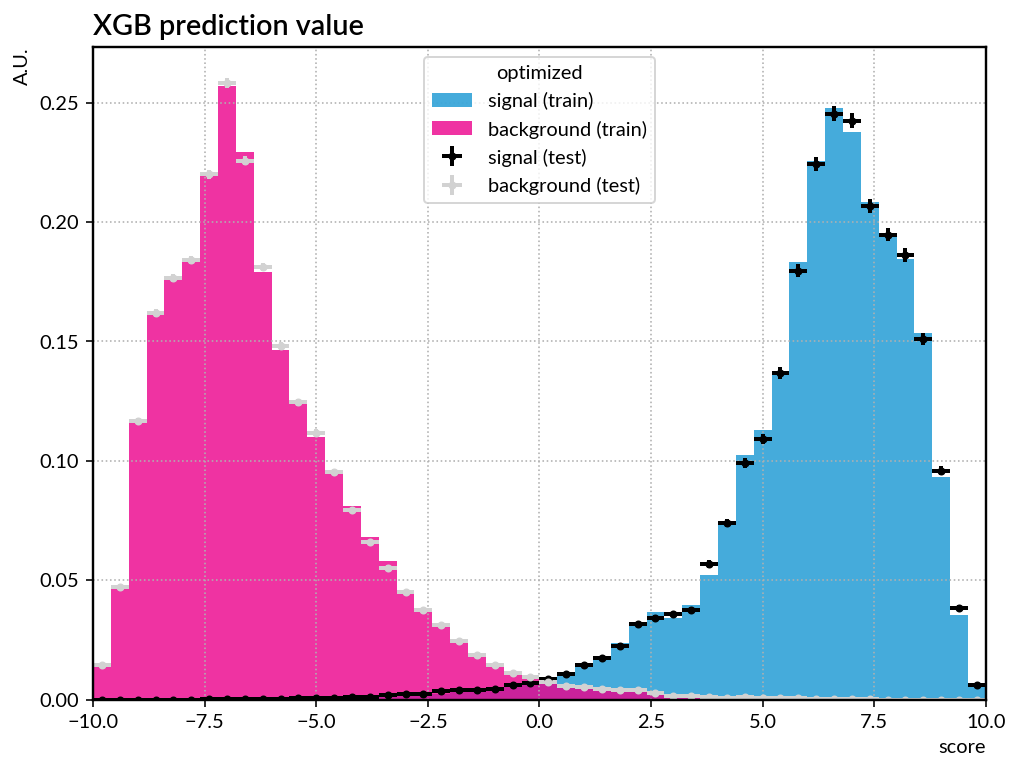

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(trainPreds_optimized[y_train], range=[-10, 10], bins=50, histtype="stepfilled", alpha=0.8, density=True, linewidth=2, label="signal (train)")
ax.hist(trainPreds_optimized[~y_train], range=[-10,10], bins=50, histtype="stepfilled", alpha=0.8, density=True, linewidth=2, label="background (train)")

hist_errorbars(preds_optimized[y_test], range=[-10, 10], bins=50, normed=True, ax=ax).set_label('signal (test)')
hist_errorbars(preds_optimized[~y_test], range=[-10, 10], bins=50, normed=True, ax=ax).set_label('background (test)')
ax.legend(title="optimized")
ax.set_xlabel("score", x=1, ha='right')
ax.set_ylabel("A.U.", y=1, ha='right')
ax.set_title("XGB prediction value", x=0, ha='left');